# **<span style="color:#121CB6;">Análisis de Riesgo Crediticio con KNN</span>**

- Comenzamos importando todas las bibliotecas necesarias.

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

sns.set_style('whitegrid')

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score

In [77]:
df_loan = pd.read_csv("Inputs/loan")
df_loan.head(7)

C:\Users\rzulantaya\AppData\Local\Temp\ipykernel_24652\4258334982.py:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_loan = pd.read_csv("Inputs/loan")


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1069639,1304742,7000.0,7000.0,7000.0,60 months,15.96,170.08,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [61]:
df_loan.drop(df_loan.columns.difference([
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 
    'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose'
]), axis=1, inplace=True)

In [62]:
df_loan.isnull().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length             44825
home_ownership             0
annual_inc                 4
verification_status        0
loan_status                0
purpose                    0
dtype: int64

There are many "Missing Values" in Column "emp_length" and few in "annual_inc".

In [63]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            887379 non-null  float64
 1   term                 887379 non-null  object 
 2   int_rate             887379 non-null  float64
 3   installment          887379 non-null  float64
 4   grade                887379 non-null  object 
 5   emp_length           842554 non-null  object 
 6   home_ownership       887379 non-null  object 
 7   annual_inc           887375 non-null  float64
 8   verification_status  887379 non-null  object 
 9   loan_status          887379 non-null  object 
 10  purpose              887379 non-null  object 
dtypes: float64(4), object(7)
memory usage: 74.5+ MB


In [64]:
df_loan.head(10)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose
0,5000.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card
1,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car
2,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business
3,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other
4,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,Current,other
5,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.0,Source Verified,Fully Paid,wedding
6,7000.0,60 months,15.96,170.08,C,8 years,RENT,47004.0,Not Verified,Current,debt_consolidation
7,3000.0,36 months,18.64,109.43,E,9 years,RENT,48000.0,Source Verified,Fully Paid,car
8,5600.0,60 months,21.28,152.39,F,4 years,OWN,40000.0,Source Verified,Charged Off,small_business
9,5375.0,60 months,12.69,121.45,B,< 1 year,RENT,15000.0,Verified,Charged Off,other


In [65]:
df_loan.annual_inc = df_loan.annual_inc.fillna(0)
df_loan.isnull().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length             44825
home_ownership             0
annual_inc                 0
verification_status        0
loan_status                0
purpose                    0
dtype: int64

- para eliminar valores nulos, la columna de ingresos anuales se rellena con el valor 0

- En esta columna, el valor 0 se completará con las condiciones correctas: "Totalmente pagado", "No cumple con la política de crédito. Estado: Totalmente pagado", "Al día".

- Por otro lado, el valor 1 se completará con las condiciones incorrectas: "Atrasado (31-120 días)", "Atrasado (16-30 días)", "En período de gracia", "Dado de baja", "Incumplido", "No cumple con la política de crédito. Estado: Dado de baja".

In [66]:
# binary classification
label_categories = [
    (0, ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid', 'Current']),
    (1, ['Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period', 
         'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'])
]

# function to apply the transformation
def classify_label(text):
    for category, matches in label_categories:
        if any(match in text for match in matches):
            return category
    return None

df_loan.loc[:, 'label'] = df_loan['loan_status'].apply(classify_label)
df_loan = df_loan.drop('loan_status', axis=1)

In [67]:
# label several label with specific grading system.
def SC_LabelEncoder1(text):
    if text == "E":
        return 1
    elif text == "D":
        return 2
    elif text == "C":
        return 3
    elif text == "B":
        return 4
    elif text == "A":
        return 5
    else:
        return 0
    
    
def SC_LabelEncoder2(text):
    if text == "< 1 year":
        return 1
    elif text == "1 year":
        return 2
    elif text == "2 years":
        return 3
    elif text == "3 years":
        return 4
    elif text == "4 years":
        return 5
    elif text == "5 years":
        return 6
    elif text == "6 years":
        return 7
    elif text == "7 years":
        return 8
    elif text == "8 years":
        return 9
    elif text == "9 years":
        return 10
    elif text == "10 years":
        return 11
    elif text == "10+ years":
        return 12
    else:
        return 0

def SC_LabelEncoder3(text):
    if text == "RENT":
        return 1
    elif text == "MORTGAGE":
        return 2
    elif text == "OWN":
        return 3
    else:
        return 0
    
df_loan["grade"] = df_loan["grade"].apply(SC_LabelEncoder1)
df_loan["emp_length"] = df_loan["emp_length"].apply(SC_LabelEncoder2)
df_loan["home_ownership"] = df_loan["home_ownership"].apply(SC_LabelEncoder3)

In [68]:
df_loan.head(10)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,label
0,5000.0,36 months,10.65,162.87,4,12,1,24000.0,Verified,credit_card,0.0
1,2500.0,60 months,15.27,59.83,3,1,1,30000.0,Source Verified,car,1.0
2,2400.0,36 months,15.96,84.33,3,12,1,12252.0,Not Verified,small_business,0.0
3,10000.0,36 months,13.49,339.31,3,12,1,49200.0,Source Verified,other,0.0
4,3000.0,60 months,12.69,67.79,4,2,1,80000.0,Source Verified,other,0.0
5,5000.0,36 months,7.90,156.46,5,4,1,36000.0,Source Verified,wedding,0.0
6,7000.0,60 months,15.96,170.08,3,9,1,47004.0,Not Verified,debt_consolidation,0.0
7,3000.0,36 months,18.64,109.43,1,10,1,48000.0,Source Verified,car,0.0
8,5600.0,60 months,21.28,152.39,0,5,3,40000.0,Source Verified,small_business,1.0
9,5375.0,60 months,12.69,121.45,4,1,1,15000.0,Verified,other,1.0


In [69]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            887379 non-null  float64
 1   term                 887379 non-null  object 
 2   int_rate             887379 non-null  float64
 3   installment          887379 non-null  float64
 4   grade                887379 non-null  int64  
 5   emp_length           887379 non-null  int64  
 6   home_ownership       887379 non-null  int64  
 7   annual_inc           887379 non-null  float64
 8   verification_status  887379 non-null  object 
 9   purpose              887379 non-null  object 
 10  label                878919 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 74.5+ MB


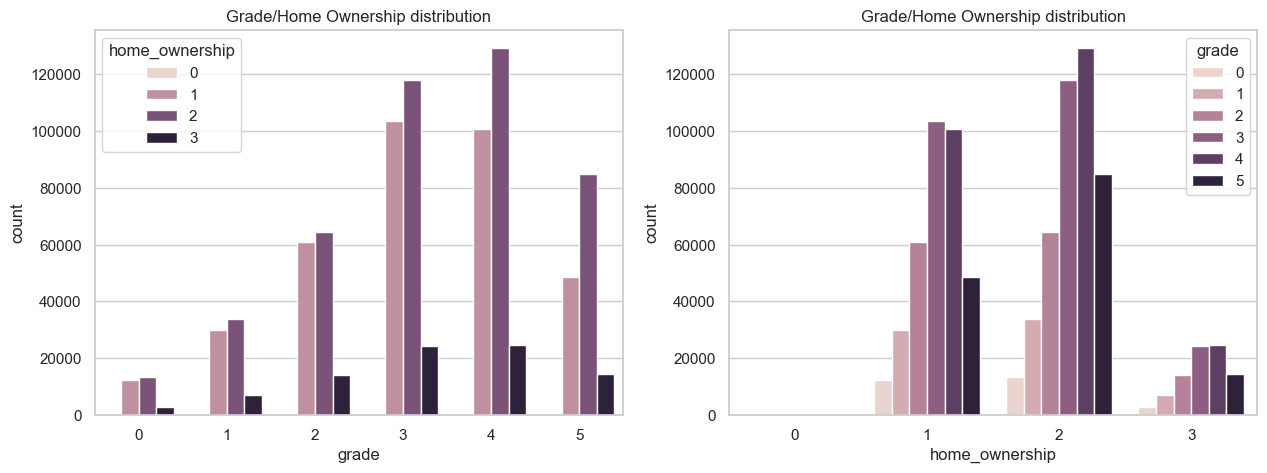

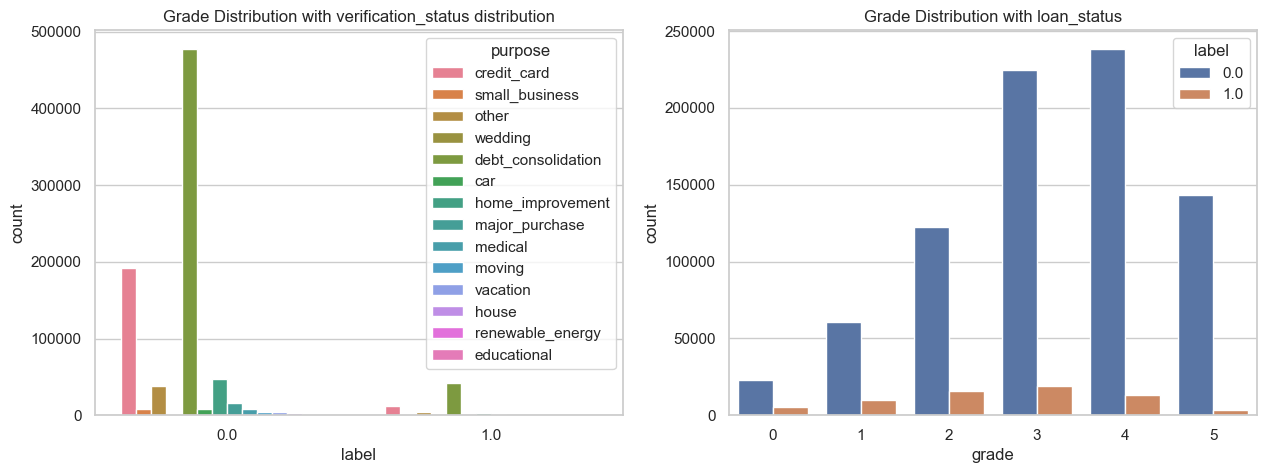

In [70]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df_loan, x='grade', hue="home_ownership", ax=ax[0]).set_title("Grade/Home Ownership distribution");
sns.countplot(data=df_loan, x='home_ownership', hue='grade', ax=ax[1]).set_title("Grade/Home Ownership distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df_loan, x='label', hue='purpose', ax=ax[0]).set_title("Grade Distribution with verification_status distribution");
sns.countplot(data=df_loan, x='grade', hue='label', ax=ax[1]).set_title("Grade Distribution with loan_status");

## Análisis:
1. El número de prestatarios con calificación alta será menor en comparación con el de calificación baja.
2. La mayoría de los prestatarios de las etiquetas 0 y 1 buscan la consolidación de deudas.
3. El mayor número de prestatarios con calificación 4 logró completar el préstamo, mientras que el mayor número de los que no lo lograron fue el de calificación 3.

Text(0.5, 1.0, 'Loan amounts grouped by purpose')

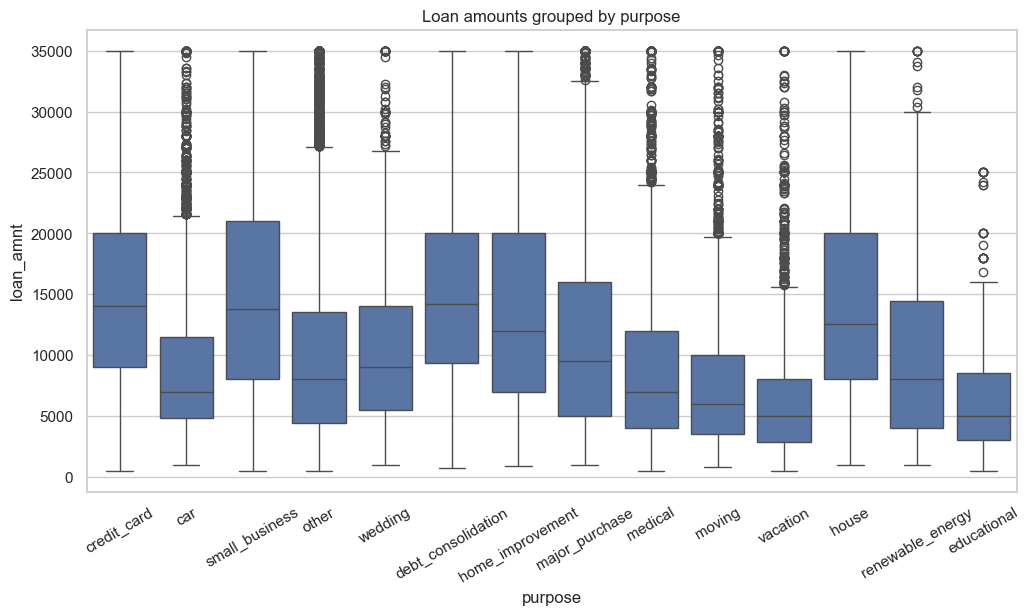

In [71]:
plt.figure(figsize=(12,6))
sns.boxplot(x='purpose', y='loan_amnt', data=df_loan)
plt.xticks(rotation=30)
plt.title('Loan amounts grouped by purpose')

## Análisis: 

Existen 5 categorías principales para el monto de crédito con los siguientes propósitos: Tarjeta de crédito, negocio MIPYME, consolidación de deudas, mejoras en el hogar y compra de vivienda.

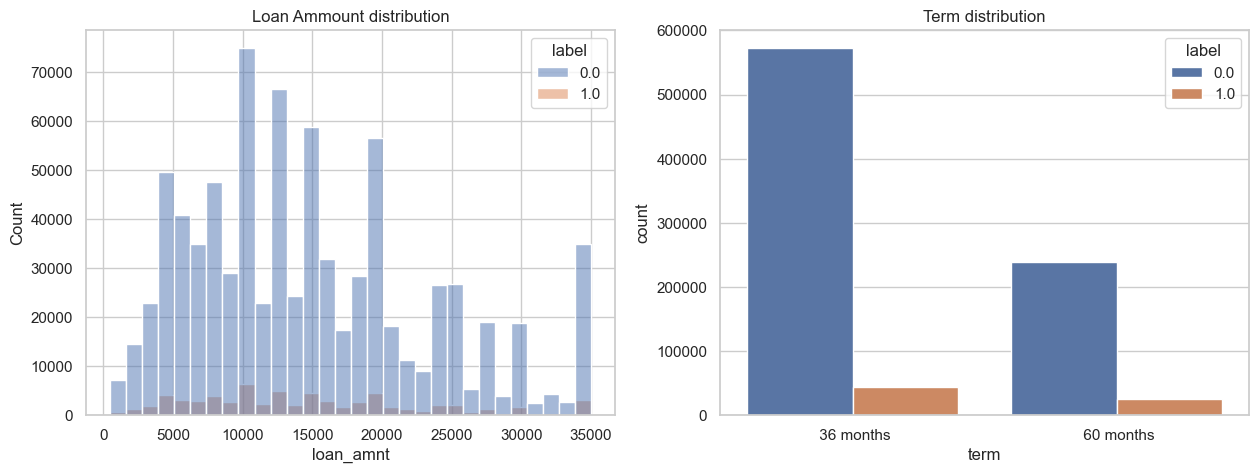

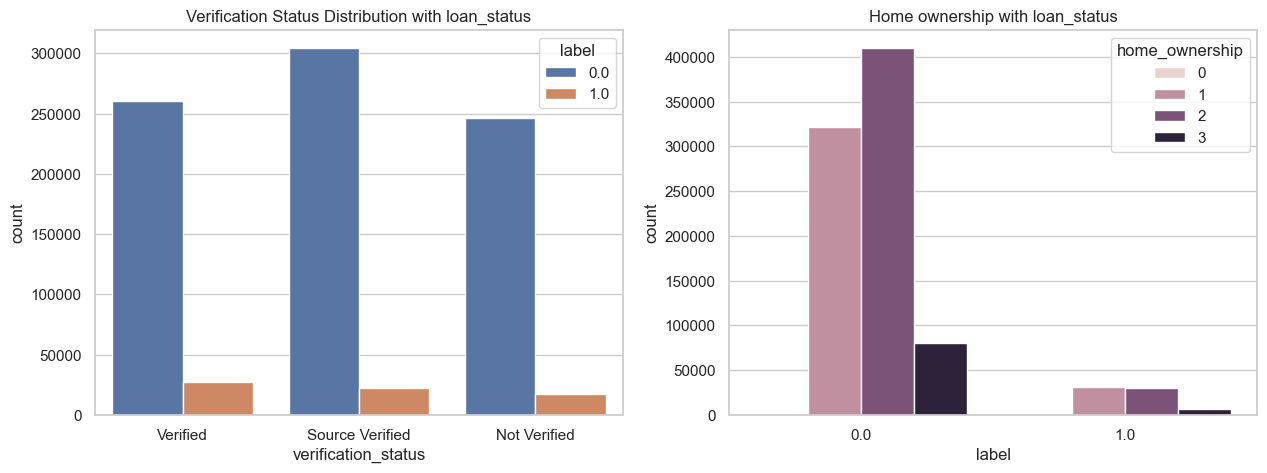

In [72]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df_loan, x='loan_amnt',hue="label", bins=30, ax=ax[0]).set_title("Loan Ammount distribution");
sns.countplot(data=df_loan, x='term', hue="label", ax=ax[1]).set_title("Term distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df_loan, hue='home_ownership', x='label', ax=ax[1]).set_title("Home ownership with loan_status");
sns.countplot(data=df_loan, x='verification_status', hue='label', ax=ax[0]).set_title("Verification Status Distribution with loan_status");

## Análisis:
1. El valor nominal de la deuda más grande es de 10 000 USD.
2. El plazo máximo es de 36 meses, mientras que para 60 meses es casi un tercio.
3. La mayoría de los créditos que se pueden pagar en su totalidad se obtienen con el estado de verificación "Verificado".

- Ver la correlación entre variables:

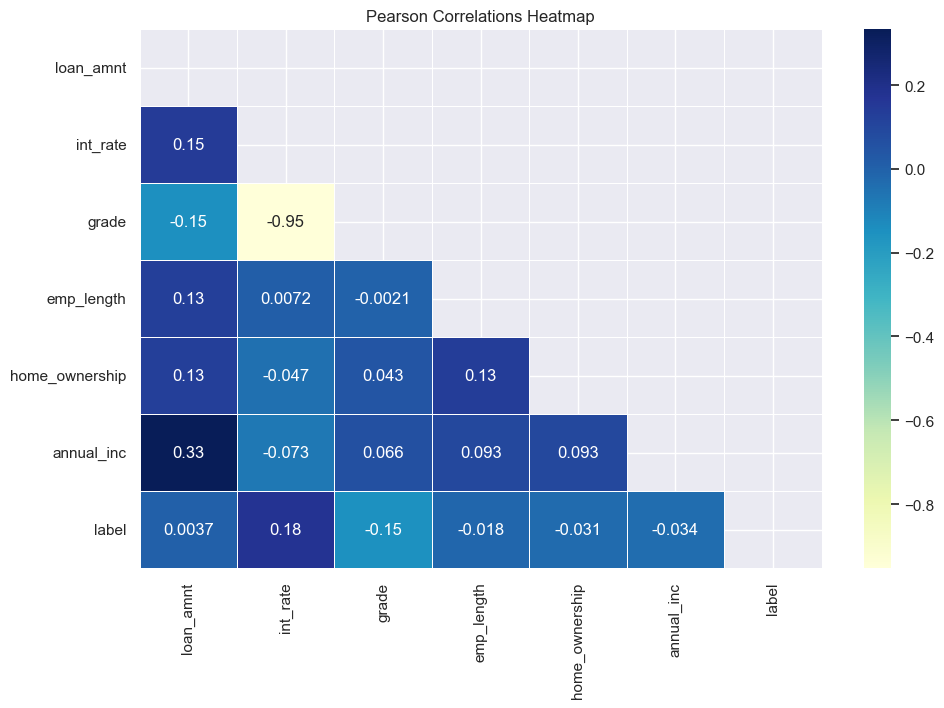

In [73]:
corr = df_loan[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc','label']].corr()
sns.set(rc={'figure.figsize':(11,7)})
sns.heatmap(corr,linewidths=.5, annot=True, cmap="YlGnBu",mask=np.triu(np.ones_like(corr, dtype=np.bool)))\
    .set_title("Pearson Correlations Heatmap");

## Análisis:
El monto del crédito depende en gran medida de los ingresos anuales del prestatario.

# **<span style="color:#121CB6;">1. Carga y comprensión del conjunto de datos</span>**

In [78]:
df_loan = pd.read_csv("Inputs/loan")
df_loan.head(7)

C:\Users\rzulantaya\AppData\Local\Temp\ipykernel_24652\4258334982.py:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_loan = pd.read_csv("Inputs/loan")


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1069639,1304742,7000.0,7000.0,7000.0,60 months,15.96,170.08,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

# **<span style="color:#121CB6;">2. Eliminación de columnas irrelevantes</span>**

In [76]:
df_loan.drop(df_loan.columns.difference(['loan_amnt','term','int_rate','installment','grade','emp_length','home_ownership',
                                         'annual_inc','verification_status','loan_status','purpose',]), 1, inplace=True)

TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 positional arguments (and 1 keyword-only argument) were given

In [ ]:
df_loan.isnull().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length             44825
home_ownership             0
annual_inc                 4
verification_status        0
loan_status                0
purpose                    0
dtype: int64

There are many "Missing Values" in Column "emp_length" and few in "annual_inc".

In [ ]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            887379 non-null  float64
 1   term                 887379 non-null  object 
 2   int_rate             887379 non-null  float64
 3   installment          887379 non-null  float64
 4   grade                887379 non-null  object 
 5   emp_length           842554 non-null  object 
 6   home_ownership       887379 non-null  object 
 7   annual_inc           887375 non-null  float64
 8   verification_status  887379 non-null  object 
 9   loan_status          887379 non-null  object 
 10  purpose              887379 non-null  object 
dtypes: float64(4), object(7)
memory usage: 74.5+ MB


In [ ]:
df_loan.head(10)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose
0,5000.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card
1,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car
2,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business
3,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other
4,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,Current,other
5,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.0,Source Verified,Fully Paid,wedding
6,7000.0,60 months,15.96,170.08,C,8 years,RENT,47004.0,Not Verified,Current,debt_consolidation
7,3000.0,36 months,18.64,109.43,E,9 years,RENT,48000.0,Source Verified,Fully Paid,car
8,5600.0,60 months,21.28,152.39,F,4 years,OWN,40000.0,Source Verified,Charged Off,small_business
9,5375.0,60 months,12.69,121.45,B,< 1 year,RENT,15000.0,Verified,Charged Off,other


In [ ]:
df_loan.annual_inc = df_loan.annual_inc.fillna(0)
df_loan.isnull().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length             44825
home_ownership             0
annual_inc                 0
verification_status        0
loan_status                0
purpose                    0
dtype: int64

- to eliminate null values, the annual income column is filled with the value 0

# **<span style="color:#121CB6;">3. Crear la columna de etiqueta: Descripción del estado del préstamo</span>**

- En esta columna, el valor 0 se completará con las condiciones correctas: "Totalmente pagado", "No cumple con la política de crédito. Estado: Totalmente pagado", "Al día".

- Por otro lado, el valor 1 se completará con las condiciones incorrectas: "Atrasado (31-120 días)", "Atrasado (16-30 días)", "En período de gracia", "Dado de baja", "Incumplido", "No cumple con la política de crédito. Estado: Dado de baja".

In [ ]:
# binary classification
label_categories = [
    (0, ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid', 'Current']),
    (1, ['Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period', 
         'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'])
]

# function to apply the transformation
def classify_label(text):
    for category, matches in label_categories:
        if any(match in text for match in matches):
            return category
    return None

df_loan.loc[:, 'label'] = df_loan['loan_status'].apply(classify_label)
df_loan = df_loan.drop('loan_status', axis=1)

In [ ]:
# label several label with specific grading system.
def SC_LabelEncoder1(text):
    if text == "E":
        return 1
    elif text == "D":
        return 2
    elif text == "C":
        return 3
    elif text == "B":
        return 4
    elif text == "A":
        return 5
    else:
        return 0
    
    
def SC_LabelEncoder2(text):
    if text == "< 1 year":
        return 1
    elif text == "1 year":
        return 2
    elif text == "2 years":
        return 3
    elif text == "3 years":
        return 4
    elif text == "4 years":
        return 5
    elif text == "5 years":
        return 6
    elif text == "6 years":
        return 7
    elif text == "7 years":
        return 8
    elif text == "8 years":
        return 9
    elif text == "9 years":
        return 10
    elif text == "10 years":
        return 11
    elif text == "10+ years":
        return 12
    else:
        return 0

def SC_LabelEncoder3(text):
    if text == "RENT":
        return 1
    elif text == "MORTGAGE":
        return 2
    elif text == "OWN":
        return 3
    else:
        return 0
    
df_loan["grade"] = df_loan["grade"].apply(SC_LabelEncoder1)
df_loan["emp_length"] = df_loan["emp_length"].apply(SC_LabelEncoder2)
df_loan["home_ownership"] = df_loan["home_ownership"].apply(SC_LabelEncoder3)

In [ ]:
df_loan.head(10)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,label
0,5000.0,36 months,10.65,162.87,4,12,1,24000.0,Verified,credit_card,0.0
1,2500.0,60 months,15.27,59.83,3,1,1,30000.0,Source Verified,car,1.0
2,2400.0,36 months,15.96,84.33,3,12,1,12252.0,Not Verified,small_business,0.0
3,10000.0,36 months,13.49,339.31,3,12,1,49200.0,Source Verified,other,0.0
4,3000.0,60 months,12.69,67.79,4,2,1,80000.0,Source Verified,other,0.0
5,5000.0,36 months,7.90,156.46,5,4,1,36000.0,Source Verified,wedding,0.0
6,7000.0,60 months,15.96,170.08,3,9,1,47004.0,Not Verified,debt_consolidation,0.0
7,3000.0,36 months,18.64,109.43,1,10,1,48000.0,Source Verified,car,0.0
8,5600.0,60 months,21.28,152.39,0,5,3,40000.0,Source Verified,small_business,1.0
9,5375.0,60 months,12.69,121.45,4,1,1,15000.0,Verified,other,1.0


In [ ]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            887379 non-null  float64
 1   term                 887379 non-null  object 
 2   int_rate             887379 non-null  float64
 3   installment          887379 non-null  float64
 4   grade                887379 non-null  int64  
 5   emp_length           887379 non-null  int64  
 6   home_ownership       887379 non-null  int64  
 7   annual_inc           887379 non-null  float64
 8   verification_status  887379 non-null  object 
 9   purpose              887379 non-null  object 
 10  label                878919 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 74.5+ MB


# **<span style="color:#121CB6;">4. Análisis exploratorio de datos</span>**

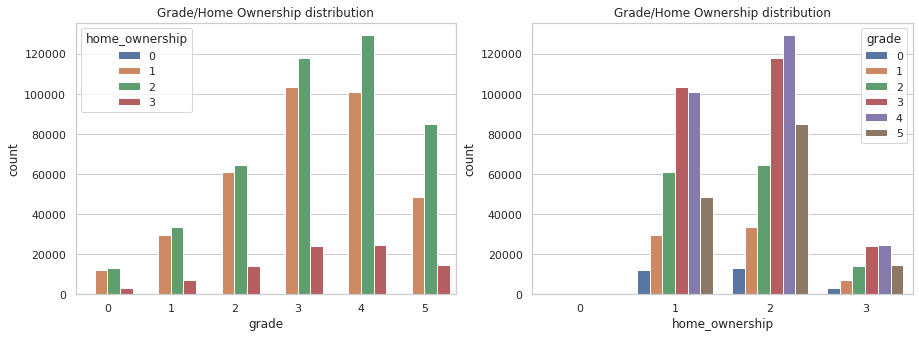

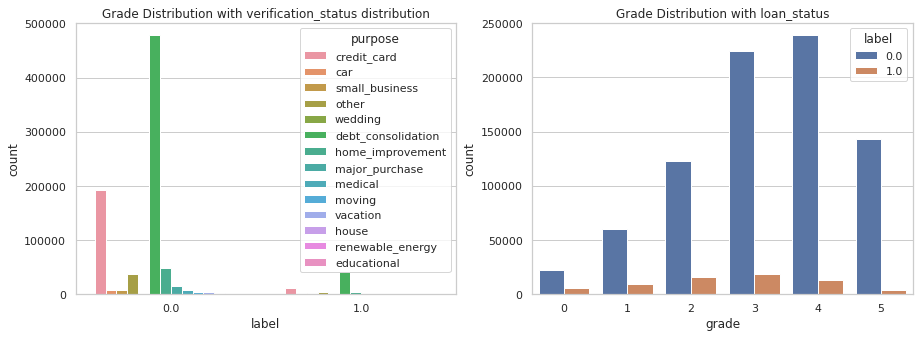

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df_loan, x='grade', hue="home_ownership", ax=ax[0]).set_title("Grade/Home Ownership distribution");
sns.countplot(data=df_loan, x='home_ownership', hue='grade', ax=ax[1]).set_title("Grade/Home Ownership distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df_loan, x='label', hue='purpose', ax=ax[0]).set_title("Grade Distribution with verification_status distribution");
sns.countplot(data=df_loan, x='grade', hue='label', ax=ax[1]).set_title("Grade Distribution with loan_status");

## Análisis:
1. El número de prestatarios con calificación alta será menor en comparación con el de calificación baja.
2. La mayoría de los prestatarios de las etiquetas 0 y 1 buscan la consolidación de deudas.
3. El mayor número de prestatarios con calificación 4 logró completar el préstamo, mientras que el mayor número de los que no lo lograron fue el de calificación 3.

Text(0.5, 1.0, 'Loan amounts grouped by purpose')

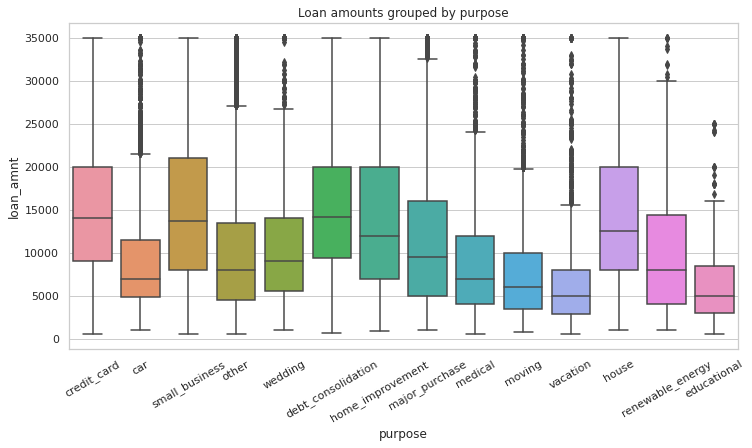

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='purpose', y='loan_amnt', data=df_loan)
plt.xticks(rotation=30)
plt.title('Loan amounts grouped by purpose')

## Análisis: 

Existen 5 categorías principales para el monto de crédito con los siguientes propósitos: Tarjeta de crédito, negocio MIPYME, consolidación de deudas, mejoras en el hogar y compra de vivienda.

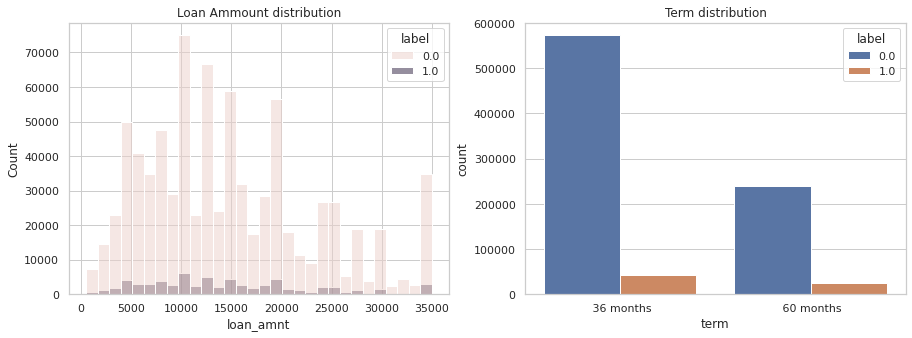

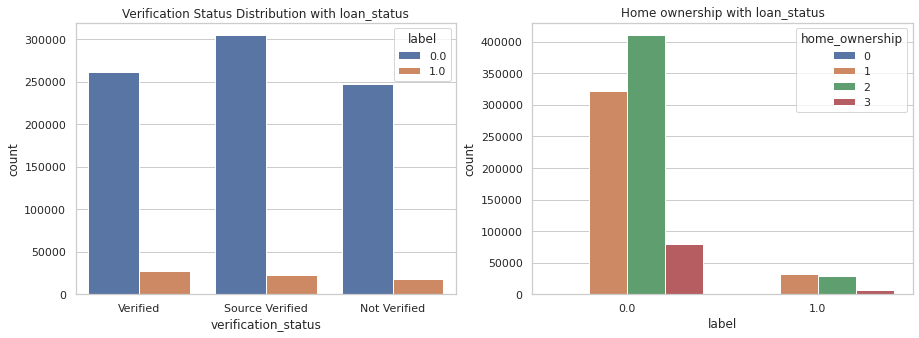

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df_loan, x='loan_amnt',hue="label", bins=30, ax=ax[0]).set_title("Loan Ammount distribution");
sns.countplot(data=df_loan, x='term', hue="label", ax=ax[1]).set_title("Term distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df_loan, hue='home_ownership', x='label', ax=ax[1]).set_title("Home ownership with loan_status");
sns.countplot(data=df_loan, x='verification_status', hue='label', ax=ax[0]).set_title("Verification Status Distribution with loan_status");

## Análisis:
1. El valor nominal de la deuda más grande es de 10 000 USD.
2. El plazo máximo es de 36 meses, mientras que para 60 meses es casi un tercio.
3. La mayoría de los créditos que se pueden pagar en su totalidad se obtienen con el estado de verificación "Verificado".

- Ver la correlación entre variables:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


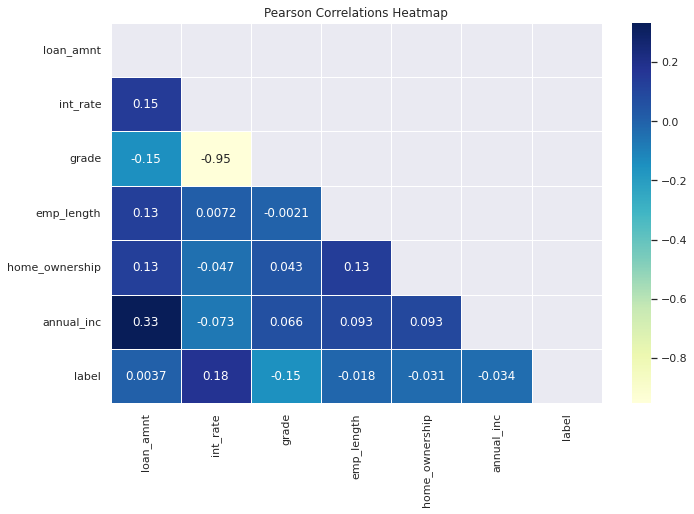

In [ ]:
corr = df_loan[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc','purpose','label']].corr()
sns.set(rc={'figure.figsize':(11,7)})
sns.heatmap(corr,linewidths=.5, annot=True, cmap="YlGnBu",mask=np.triu(np.ones_like(corr, dtype=np.bool)))\
    .set_title("Pearson Correlations Heatmap");

## Analysis :
The amount of credit is very dependent on the annual income of the borrower

# **<span style="color:#121CB6;">5. Pra-Processing data for Discrete Coloumn</span>**

In [ ]:
# use LabelEncoder() to encode another category column:
for col in ["verification_status", "purpose","term"]:
    le = LabelEncoder()
    le.fit(df_loan[col])
    df_loan[col] = le.transform(df_loan[col])
df_loan.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,label
0,5000.0,0,10.65,162.87,4,12,1,24000.0,2,1,0.0
1,2500.0,1,15.27,59.83,3,1,1,30000.0,1,0,1.0
2,2400.0,0,15.96,84.33,3,12,1,12252.0,0,11,0.0
3,10000.0,0,13.49,339.31,3,12,1,49200.0,1,9,0.0
4,3000.0,1,12.69,67.79,4,2,1,80000.0,1,9,0.0


In [ ]:
df_loan.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
purpose                   0
label                  8460
dtype: int64

In [ ]:
df_loan.label = df_loan.label.fillna(1)

# **<span style="color:#121CB6;">6. Clustering</span>**

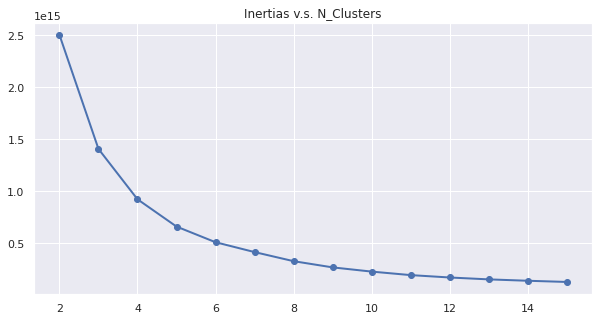

In [ ]:
inertias = []

for i in range(2,16):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_loan)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.title('Inertias v.s. N_Clusters')
plt.plot(np.arange(2,16),inertias, marker='o', lw=2);

## Analysis: 
"Elbow" on the chart above is at 4. The number of clusters must be 4.

In [ ]:
km = KMeans(n_clusters=4, random_state=0)
clusters = km.fit_predict(df_loan)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


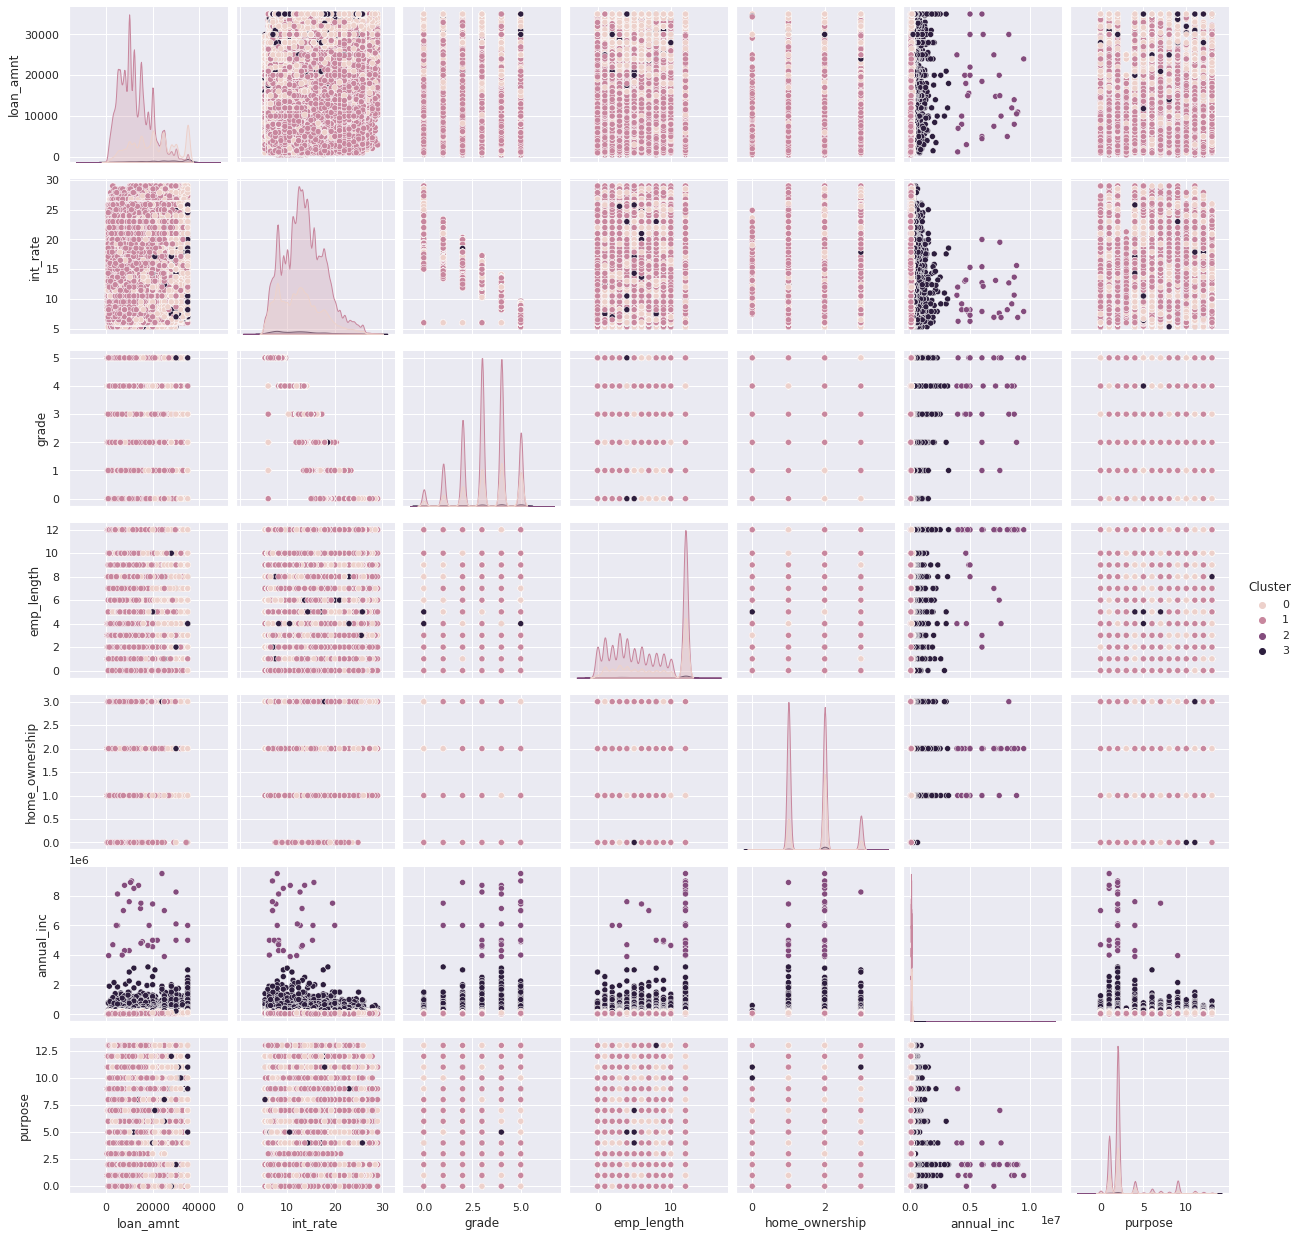

In [ ]:
df_clustered = df_loan[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose']]
df_clustered["Cluster"] = clusters
sns.pairplot(df_clustered[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose'
                           , "Cluster"]], hue="Cluster");

# **<span style="color:#121CB6;">7. Predicting Risk: Using the K-Nearest Neighbors Classification Model</span>**

In [ ]:
X, y = df_loan.drop("label", axis=1), df_loan["label"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=0)

In [ ]:
max_score = 0
max_k = 0
for k in range(1, 100):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train,y_train)
    score = f1_score(y_test, neigh.predict(X_test),average='micro')
    if score > max_score:
        max_k = k
        max_score = score

In [ ]:
print('If we use K-Nearest Neighbors Classification, then the value of K is',str(max_k),' to get the best prediction, then the average accuracy is ', max_score)

If we use K-Nearest Neighbors Classification, then the value of K is 30  to get the best prediction, then the average accuracy is  0.9142870021862111


Classification with other ML models

Since the KNN (K-Nearest Neighbors) Classification takes a lot of time and memory to predict, it is possible to use other ML models such as SVC, DecisionTree, RandomForest, and GaussianNaiveBayes.

However, in this notebook, We use KNN Model Only, and it is done and has got a good accuracy = 91.4%

In [ ]:
# use LabelEncoder() to encode another category column:
for col in ["verification_status", "purpose","term"]:
    le = LabelEncoder()
    le.fit(df_loan[col])
    df_loan[col] = le.transform(df_loan[col])
df_loan.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,label
0,5000.0,0,10.65,162.87,4,12,1,24000.0,2,1,0.0
1,2500.0,1,15.27,59.83,3,1,1,30000.0,1,0,1.0
2,2400.0,0,15.96,84.33,3,12,1,12252.0,0,11,0.0
3,10000.0,0,13.49,339.31,3,12,1,49200.0,1,9,0.0
4,3000.0,1,12.69,67.79,4,2,1,80000.0,1,9,0.0


In [ ]:
df_loan.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
purpose                   0
label                  8460
dtype: int64

In [ ]:
df_loan.label = df_loan.label.fillna(1)

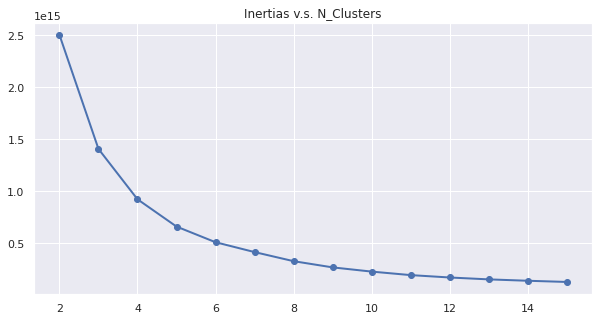

In [ ]:
inertias = []

for i in range(2,16):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_loan)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.title('Inertias v.s. N_Clusters')
plt.plot(np.arange(2,16),inertias, marker='o', lw=2);

## Analysis: 
"Elbow" on the chart above is at 4. The number of clusters must be 4.

In [ ]:
km = KMeans(n_clusters=4, random_state=0)
clusters = km.fit_predict(df_loan)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


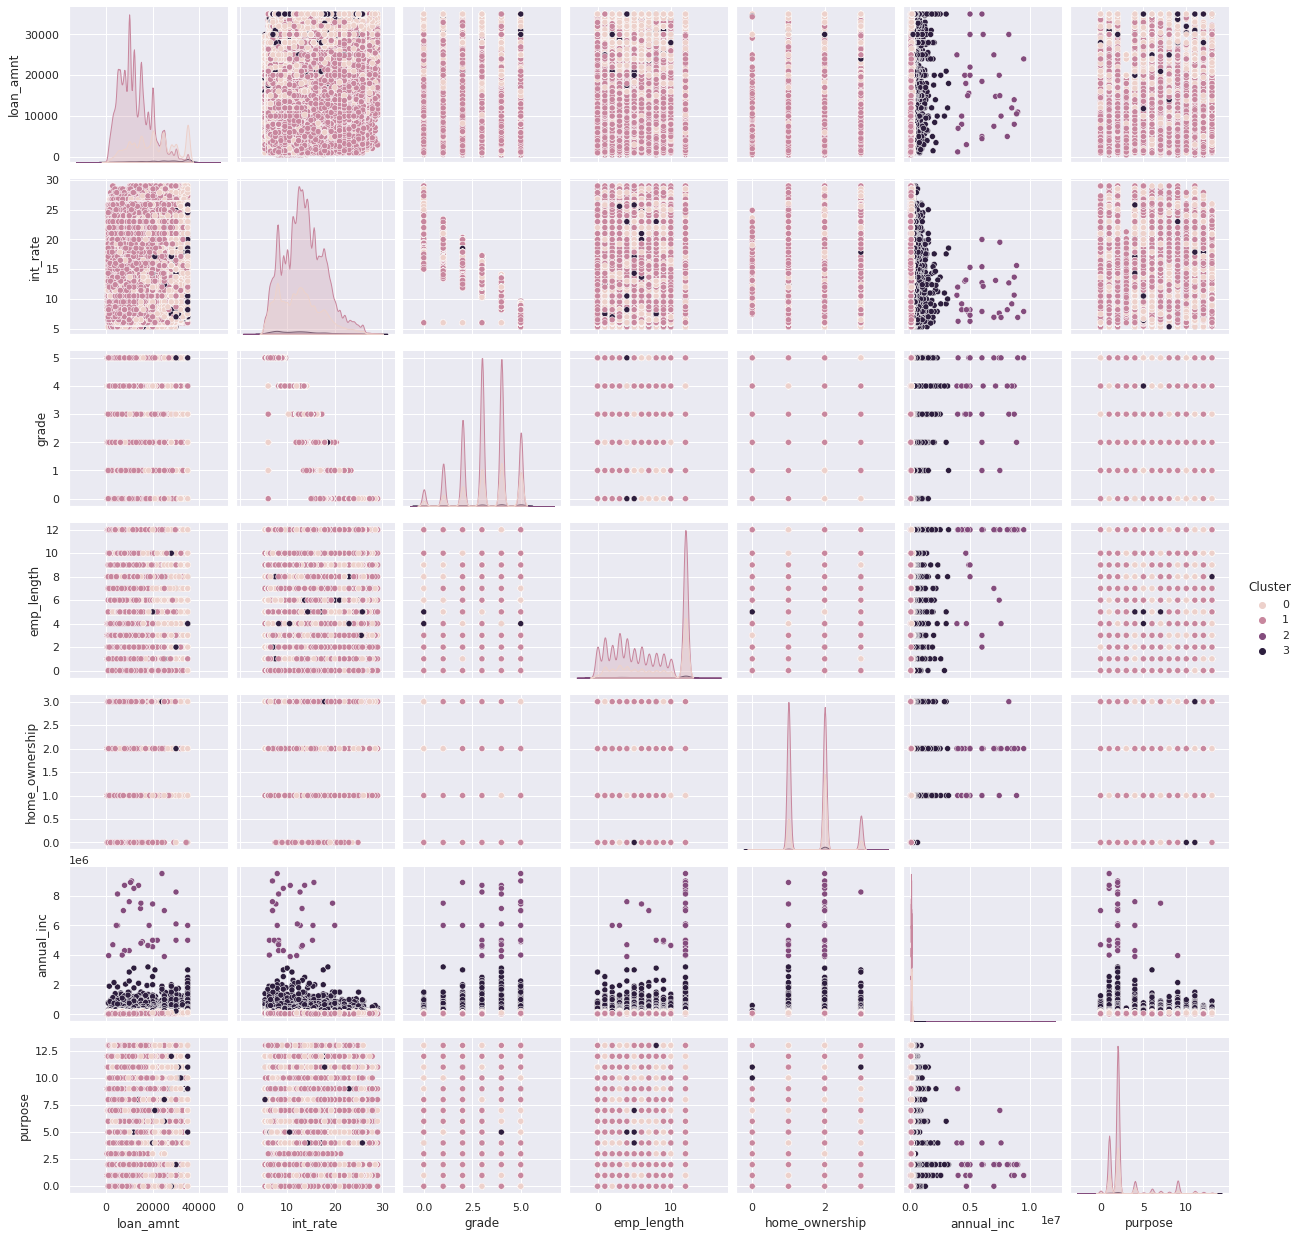

In [ ]:
df_clustered = df_loan[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose']]
df_clustered["Cluster"] = clusters
sns.pairplot(df_clustered[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose'
                           , "Cluster"]], hue="Cluster");

In [ ]:
X, y = df_loan.drop("label", axis=1), df_loan["label"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=0)

In [ ]:
max_score = 0
max_k = 0
for k in range(1, 100):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train,y_train)
    score = f1_score(y_test, neigh.predict(X_test),average='micro')
    if score > max_score:
        max_k = k
        max_score = score

In [ ]:
print('If we use K-Nearest Neighbors Classification, then the value of K is',str(max_k),' to get the best prediction, then the average accuracy is ', max_score)

If we use K-Nearest Neighbors Classification, then the value of K is 30  to get the best prediction, then the average accuracy is  0.9142870021862111


Classification with other ML models

Since the KNN (K-Nearest Neighbors) Classification takes a lot of time and memory to predict, it is possible to use other ML models such as SVC, DecisionTree, RandomForest, and GaussianNaiveBayes.

However, in this notebook, We use KNN Model Only, and it is done and has got a good accuracy = 91.4%